In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, BatchNormalization, Dropout
from keras import optimizers

%matplotlib inline
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [110]:
v1 = pd.read_csv('example_data_new/v1_obfs.csv')
v2 = pd.read_csv('example_data_new/v2_obfs.csv')
v4 = pd.read_csv('example_data_new/v4_obfs.csv')
v8 = pd.read_csv('example_data_new/v8_obfs.csv')
v11 = pd.read_csv('example_data_new/v11_obfs.csv')
v14 = pd.read_csv('example_data_new/v14_obfs.csv')
v15 = pd.read_csv('example_data_new/v15_obfs.csv')
v19 = pd.read_csv('example_data_new/v19_obfs.csv')

In [111]:
v = [v1, v2, v4, v8, v11, v14, v15, v19]
v_dict = {'v1': v1, 'v2': v2, 'v4': v4, 'v8': v8,
          'v11':v11, 'v14': v14, 'v15': v15, 'v19': v19}


In [112]:
kmeans = pd.read_pickle('k_means_strong_features_v.pkl')

In [113]:
cluster_0 = kmeans[kmeans['cluster']==0][['File', 'column']]
data_0 = []
for _, row in cluster_0.iterrows():
    data = v_dict[row['File']][row['column']]
    if not data.isnull().any():
        data_0.append(data.values[:5113])
    else:
        continue
print (len(data_0))


cluster_1 = kmeans[kmeans['cluster']==1][['File', 'column']]
data_1 = []
for _, row in cluster_1.iterrows():
    data = v_dict[row['File']][row['column']]
    if not data.isnull().any():
        data_1.append(data.values[:5113])
    else:
        continue
print (len(data_1))



data_01 = []
for _, row in  kmeans[['File', 'column']].iterrows():
    data = v_dict[row['File']][row['column']]
    if not data.isnull().any():
        data_01.append(data.values[:5113])
    else:
        continue
print (len(data_01))
    

45
60
105


### Functions

In [114]:

def sliding_window_2d(data, train_size, test_size, step_size):
    '''sliding window with an intersection between windows
    by size of _step_size_'''
    xy = []
    line_size = data.shape[1]
    for row in range(0, data.shape[0]):
        for start in range(0, line_size, step_size):
            stop =  start+train_size+test_size
            if stop <= line_size:
                xy.append(data[row, start: stop])
    return np.array(xy)


def xy_split(data, train_size):
    """split sliding windows into X and Y,
       input and output of the model.
    """
    x, y = data[:, :train_size], data[:, train_size:]
    return x, y


def norm_ts(data, transpose=True):
    """
    scaler ->  TS∈[0,1] .
    """
    scaler = MinMaxScaler(copy=True)
    if transpose:
        scaled01 = scaler.fit_transform(data.T).T
    else:
        scaled01 = scaler.fit_transform(data)
    return np.squeeze(scaled01), scaler


def inverse_norm(data, scaler):
    """ inverse scaling
    """
    return scaler.inverse_transform(data)


def train_test_reshape(train_x, test_x):
    """reshape + split train test 50-50"""
    return np.expand_dims(train_x, axis=2), np.expand_dims(test_x, axis=2)


def naive_prediction_mae(x_test, y_test):
    """prediction using last value"""
    naive_pred = 0
    n = x_test.shape[0]
    for i in range(n): 
        naive_pred += np.mean(np.abs(x_test[i, -1] - y_test[i, :]))
    naive_pred /= n
    print ('naive model = {0:0.4f}'.format(naive_pred))
    return None


def model_mae(model, x_test, y_test, scaler, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    n = x_test.shape[0]
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None

def model_mae_n(model, x_test, y_test, scaler, n, inv_norm=False):
    """calculation MAE for prediction"""
    y_pred = model.predict(x_test)
    if inv_norm:
        y_pred=inverse_norm(y_pred.T, scaler).T
    mae = 0
    for i in range(n): 
        mae += np.mean(np.abs(y_pred[i, :] - y_test[i, :]))
    mae /= n
    print ('current model = {0:0.4f}'.format(mae))
    return None


### Parameters of Sliding window


In [129]:

train_size = 168
test_size = 24
# line_size = v1.shape[1]
step_size = 10
train_vs_test = .75
# train_test_split = int(train_vs_test * v_1_2_4.shape[0])

### Normalization

In [130]:
data= np.array(data_01)
train_test_split = int(train_vs_test * data.shape[1])
print (data.shape)

train_xy = data[:, :train_test_split]

test_xy = data[:, train_test_split:]

train_xy, scaler = norm_ts(train_xy)


train_xy = sliding_window_2d(data=train_xy,
                             train_size=train_size,
                             test_size=test_size,
                             step_size=step_size)

print(test_xy.shape)

test_xy = sliding_window_2d(data=test_xy,
                            train_size=train_size,
                            test_size=test_size,
                            step_size=step_size)

test_xy.shape
test_x_original, test_y_original = xy_split(test_xy, train_size)
test_x, scaler_test = norm_ts(test_x_original, transpose=True)


train_x, train_y = xy_split(train_xy, train_size)
train_x, test_x = train_test_reshape(train_x, test_x)

print (train_x.shape, test_x.shape, test_x_original.shape, test_y_original.shape)

(105, 5113)
(105, 1279)
(38325, 168, 1) (11445, 168, 1) (11445, 168) (11445, 24)


### CNN network

In [131]:

def cnn_model(x_train, y_train, batch_size, epochs=50, n_steps_for_train=train_size):
    
    
    input_dim = n_steps_for_train
    model = Sequential()
    model.add(Convolution1D(filters=6, kernel_size=4, input_shape=(input_dim ,1)))
    model.add(Flatten())
    model.add(Dense(units=64, kernel_initializer='normal'))
    # model.add(BatchNormalization())
    model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(units=60, actiivation='relu'))
    # model.add(Dense(units=40, activation='relu'))
    model.add(Dense(units=24, activation='linear'))


    sgd = optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error',
                  optimizer='sgd',
                  metrics=['mae'])

    history = model.fit(x_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, validation_split=.3, verbose=2)
    return model, history

In [133]:
model, history = cnn_model(x_train=train_x, y_train=train_y, batch_size=4, epochs=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 26827 samples, validate on 11498 samples
Epoch 1/20
 - 6s - loss: 0.0264 - mean_absolute_error: 0.1024 - val_loss: 0.0226 - val_mean_absolute_error: 0.0951
Epoch 2/20
 - 6s - loss: 0.0199 - mean_absolute_error: 0.0865 - val_loss: 0.0205 - val_mean_absolute_error: 0.0881
Epoch 3/20
 - 6s - loss: 0.0186 - mean_absolute_error: 0.0820 - val_loss: 0.0195 - val_mean_absolute_error: 0.0847
Epoch 4/20
 - 6s - loss: 0.0179 - mean_absolute_error: 0.0796 - val_loss: 0.0190 - val_mean_absolute_error: 0.0829
Epoch 5/20
 - 6s - loss: 0.0174 - mean_absolute_error: 0.0780 - val_loss: 0.0186 - val_mean_absolute_error: 0.0811
Epoch 6/20
 - 6s - loss: 0.0171 - mean_absolute_error: 0.0768 - val_loss: 0.0183 - val_mean_absolute_error: 0.0808
Epoch 7/20
 - 6s - loss: 0.0168 - mean_absolute_error: 0.0758 - val_loss: 0.0183 - val_mean_absolute_error: 0.0807
Epoch 8/20
 - 6s - loss: 

### Comparison to Naive model

In [134]:
naive_prediction_mae(x_test=test_x_original, y_test=test_y_original)
model_mae(model, x_test=test_x, y_test=test_y_original,
          scaler=scaler_test, inv_norm=True)


naive model = 432.0850
current model = 171.4756


### Comparing to Benchmark

In [139]:
import pickle
with open('benchmark.pkl', 'rb') as handle:
    benchmark = pickle.load(handle)


model_mae(model,
          x_test=benchmark['test_x'], 
          y_test=benchmark['test_y_original'],
          scaler=benchmark['scaler_benchmark'],
          inv_norm=True)


current model = 625.7980


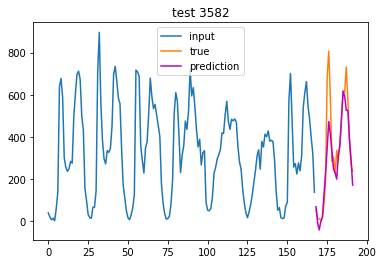

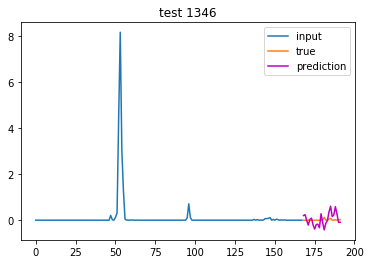

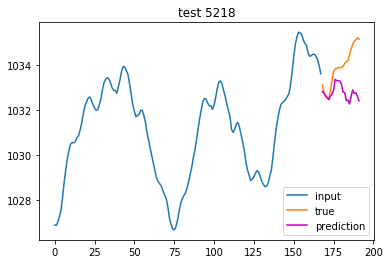

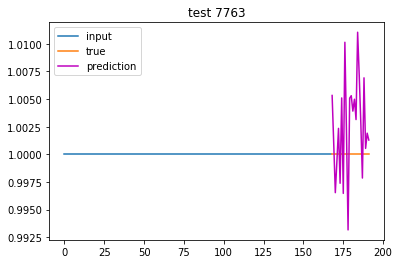

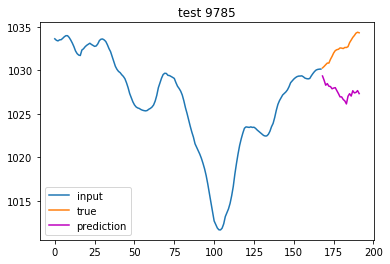

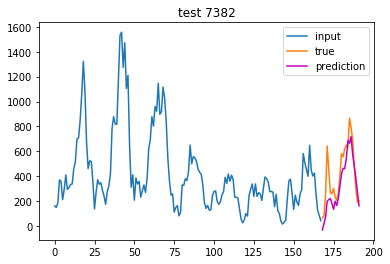

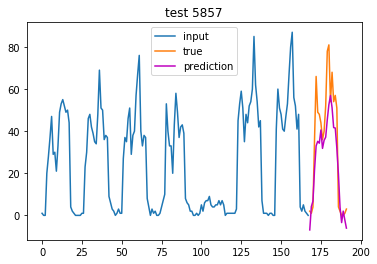

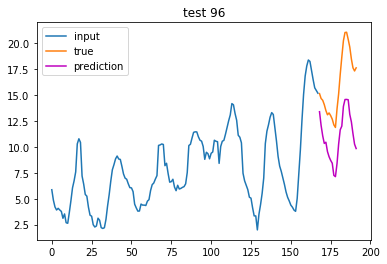

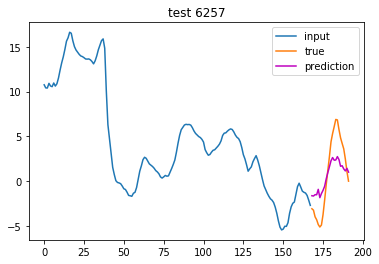

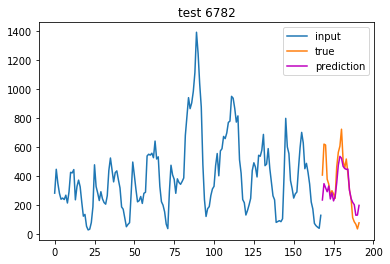

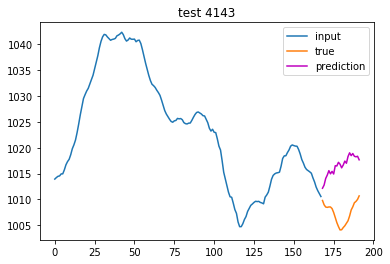

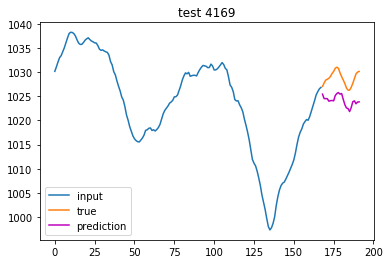

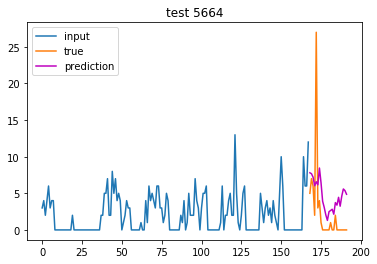

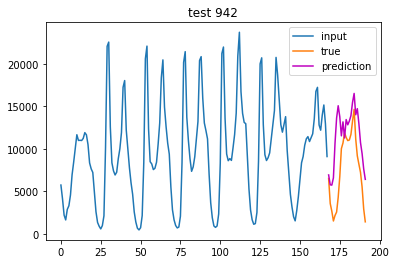

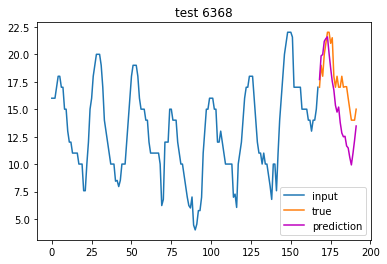

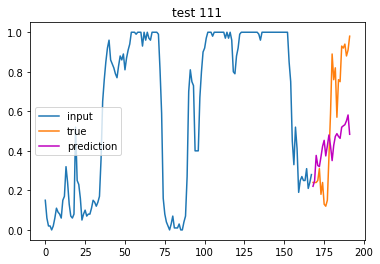

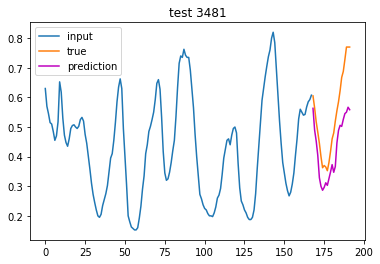

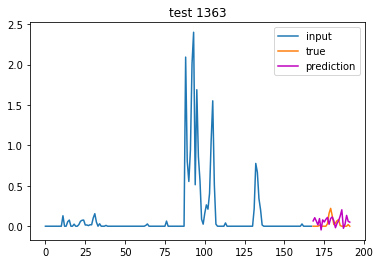

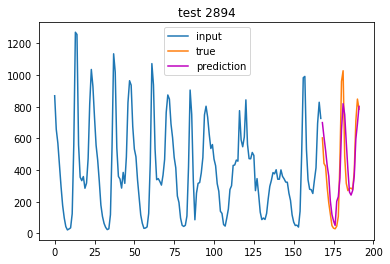

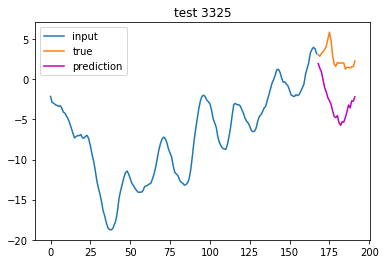

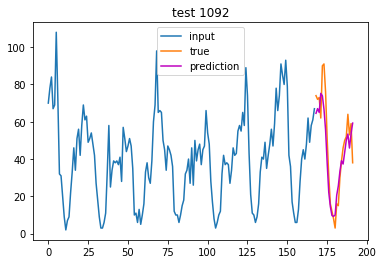

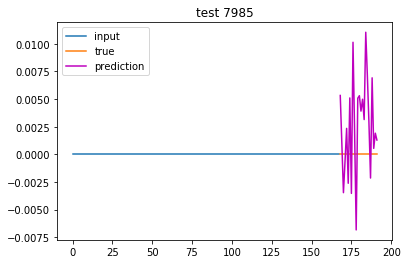

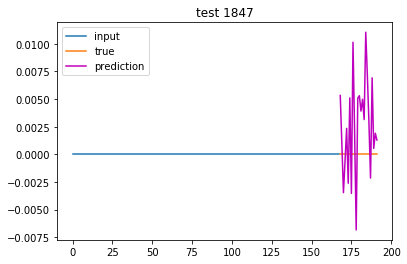

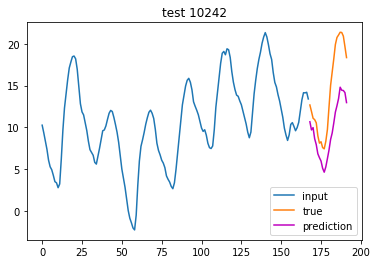

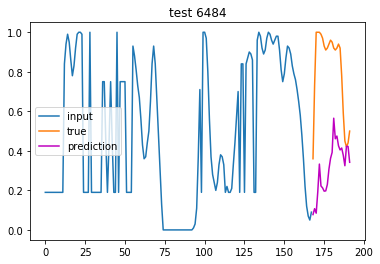

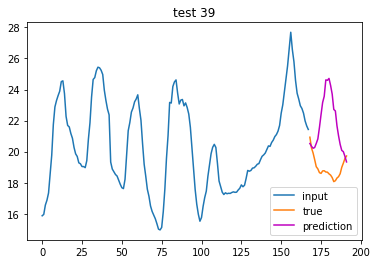

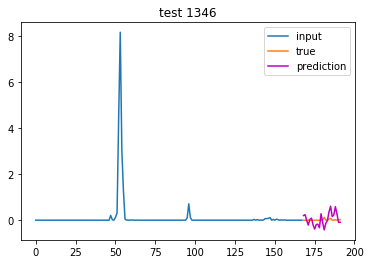

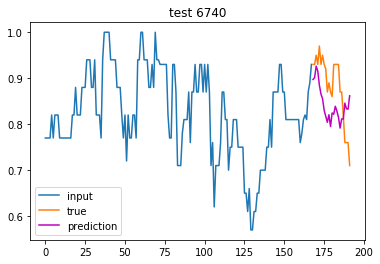

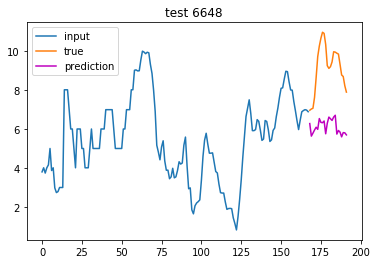

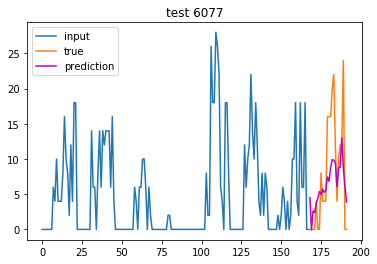

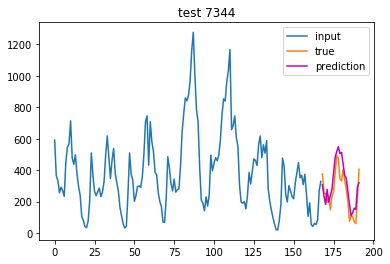

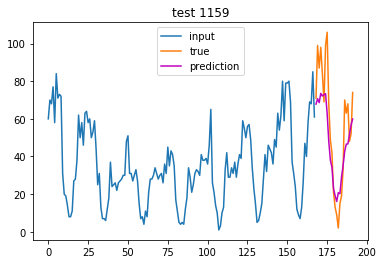

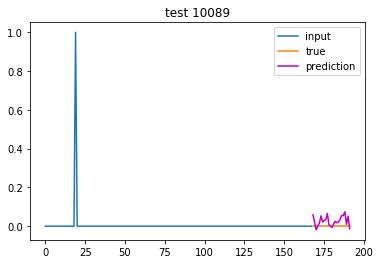

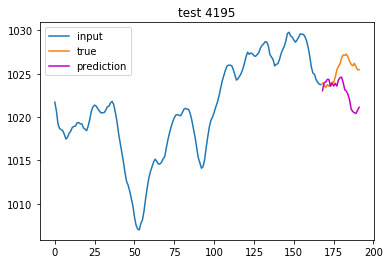

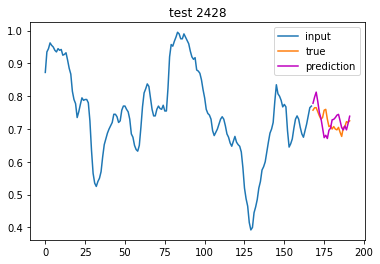

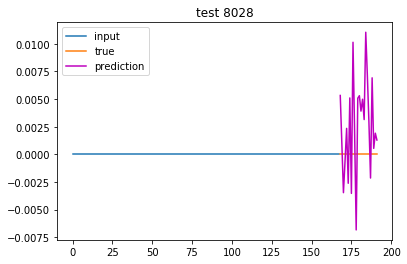

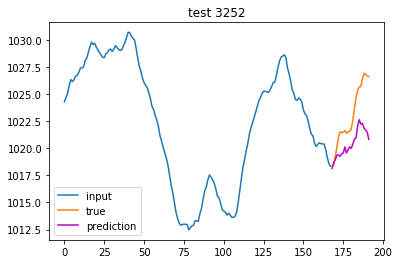

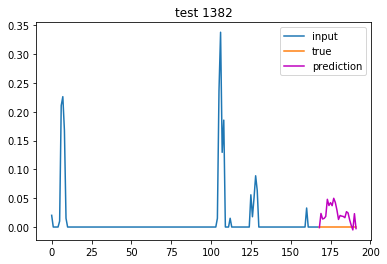

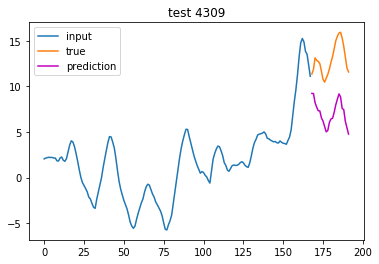

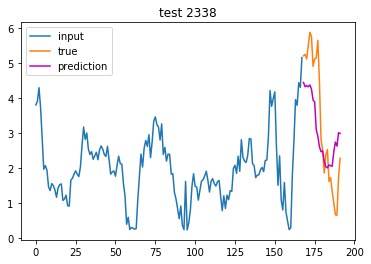

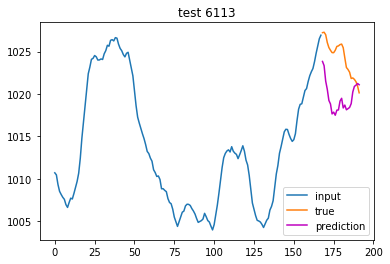

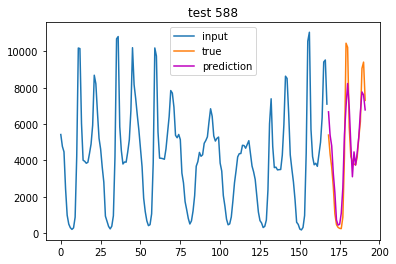

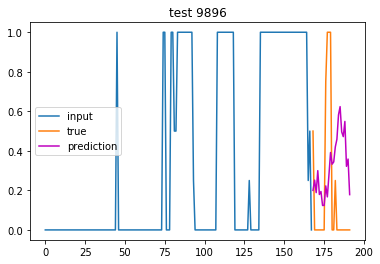

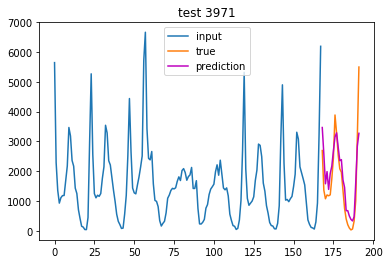

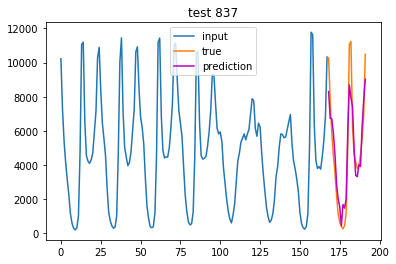

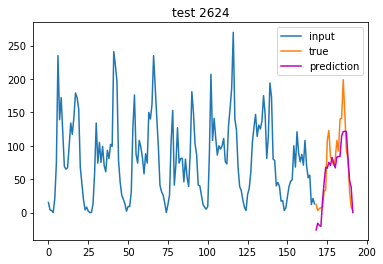

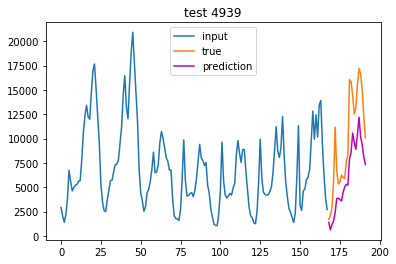

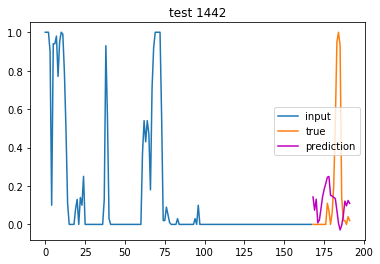

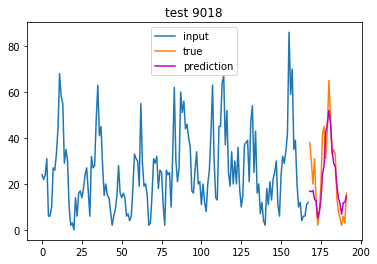

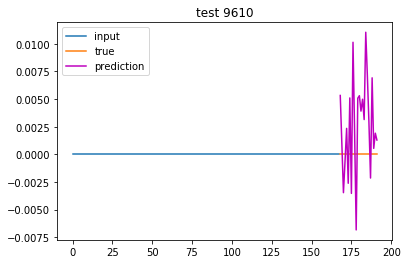

In [135]:
plt.rcParams.update({'figure.max_open_warning': 50})
np.random.seed(seed=123)
pred = model.predict(test_x)
pred = inverse_norm(pred.T, scaler=scaler_test).T
for i in np.random.randint(0, test_x.shape[0], 50):
    plt.figure()
    plt.plot(range(train_size), test_x_original[i], label='input')
    plt.plot(range(train_size, train_size+test_size), test_y_original[i], label='true')
    plt.plot(range(train_size, train_size+test_size), pred[i], c='m', label='prediction')
    plt.title(f'test {i}')
    plt.legend()